### Imports

In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import folium
from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

### Functions

In [2]:
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

def date_time(table_cells):
    """
    This function returns the data and time from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out

def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass

def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name 

def plot_confusion_matrix(y,y_predict):
    """this function plots the confusion matrix"""
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['did not land', 'land']);
    ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show()

### Collecting API Data

In [3]:
url = 'https://api.spacexdata.com/v4/launches/past'
response = requests.get(url)
data_api = pd.json_normalize(response.json())
data_api.shape

(187, 43)

In [4]:
###NÃO RODAR DUAS VEZES!!!!!!!!!!

data_api = data_api[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

data_api = data_api[data_api['cores'].map(len)==1]
data_api = data_api[data_api['payloads'].map(len)==1]

data_api['cores'] = data_api['cores'].map(lambda x : x[0])
data_api['payloads'] = data_api['payloads'].map(lambda x : x[0])

data_api['date'] = pd.to_datetime(data_api['date_utc']).dt.date
data_api = data_api[data_api['date'] <= datetime.date(2020, 11, 13)]

data_api.shape

(94, 7)

In [5]:
getBoosterVersion(data_api)
getLaunchSite(data_api)
getPayloadData(data_api)
getCoreData(data_api)

In [6]:
launch_dict = {'FlightNumber': list(data_api['flight_number']),
'Date': list(data_api['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

data = pd.DataFrame(launch_dict)

In [7]:
data_falcon9 = data[data['BoosterVersion'] != 'Falcon 1']
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


### Data Wrangling

In [8]:
# Calculate the mean value of PayloadMass column
PL_mean = np.mean(data_falcon9['PayloadMass'])
# Replace the np.nan values with its mean value
data_falcon9 = data_falcon9.fillna({'PayloadMass': PL_mean})
print(data_falcon9['LaunchSite'].value_counts())

LaunchSite
CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: count, dtype: int64


In [9]:
landing_outcomes = data_falcon9['Outcome'].value_counts()
for i, outcome in enumerate(landing_outcomes.keys()):
    # print(i, outcome)
    pass
bad_outcome = set(landing_outcomes.keys()[[1,3,5,6,7]])
print(bad_outcome)
def classify_outcome(outcome):
    if outcome in bad_outcome:
        return 0
    else:
        return 1

data_falcon9['Outcome'] = data_falcon9['Outcome'].apply(classify_outcome)

{'None None', 'False Ocean', 'False ASDS', 'None ASDS', 'False RTLS'}


In [10]:
data_falcon9['Outcome'].value_counts()

Outcome
1    60
0    30
Name: count, dtype: int64

### Web Scrapping

In [11]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"
response = requests.get(static_url)
if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
else:
    print("Erro ao acessar a página:", response.status_code)

html_tables = soup.find_all('table')
launch_table = html_tables[2]

In [12]:
th_elements = launch_table.find_all('th')
column_names = []
for th in th_elements:
    column_name = extract_column_from_header(th)
    if column_name is not None and len(column_name) > 0:
        column_names.append(column_name)
print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


In [13]:
launch_dict= dict.fromkeys(column_names)

del launch_dict['Date and time ( )']

launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

extracted_row = 0
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
    for rows in table.find_all("tr"):
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        row=rows.find_all('td')
        if flag:
            extracted_row += 1
            launch_dict['Flight No.'].append(flight_number)
            
            datatimelist=date_time(row[0])
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)
            
            time = datatimelist[1]
            launch_dict['Time'].append(time)
              
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
            launch_dict['Version Booster'].append(bv)
            
            launch_site = row[2].a.string
            launch_dict['Launch site'].append(launch_site)
            
            payload = row[3].a.string
            launch_dict['Payload'].append(payload)
            
            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass)
            
            orbit = row[5].a.string
            launch_dict['Orbit'].append(orbit)
            
            try:
                customer = row[6].a.string
            except:
                customer = row[6]
            launch_dict['Customer'].append(customer)
            
            launch_outcome = list(row[7].strings)[0]
            launch_dict['Launch outcome'].append(launch_outcome)
            
            booster_landing = landing_status(row[8])
            launch_dict['Booster landing'].append(booster_landing)

In [14]:
df= pd.DataFrame({ key:pd.Series(value) for key, value in launch_dict.items() })
df

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,F9 v1.07B0003.18,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.07B0004.18,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.07B0005.18,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success\n,F9 v1.07B0006.18,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success\n,F9 v1.07B0007.18,No attempt\n,1 March 2013,15:10
...,...,...,...,...,...,...,...,...,...,...,...
116,117,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success\n,F9 B5B1051.10657,Success,9 May 2021,06:42
117,118,KSC,Starlink,"~14,000 kg",LEO,SpaceX,Success\n,F9 B5B1058.8660,Success,15 May 2021,22:56
118,119,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success\n,F9 B5B1063.2665,Success,26 May 2021,18:59
119,120,KSC,SpaceX CRS-22,"3,328 kg",LEO,NASA,Success\n,F9 B5B1067.1668,Success,3 June 2021,17:29


### Exploratory Analysis

In [15]:
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,0,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,0,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,0,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,0,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,0,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


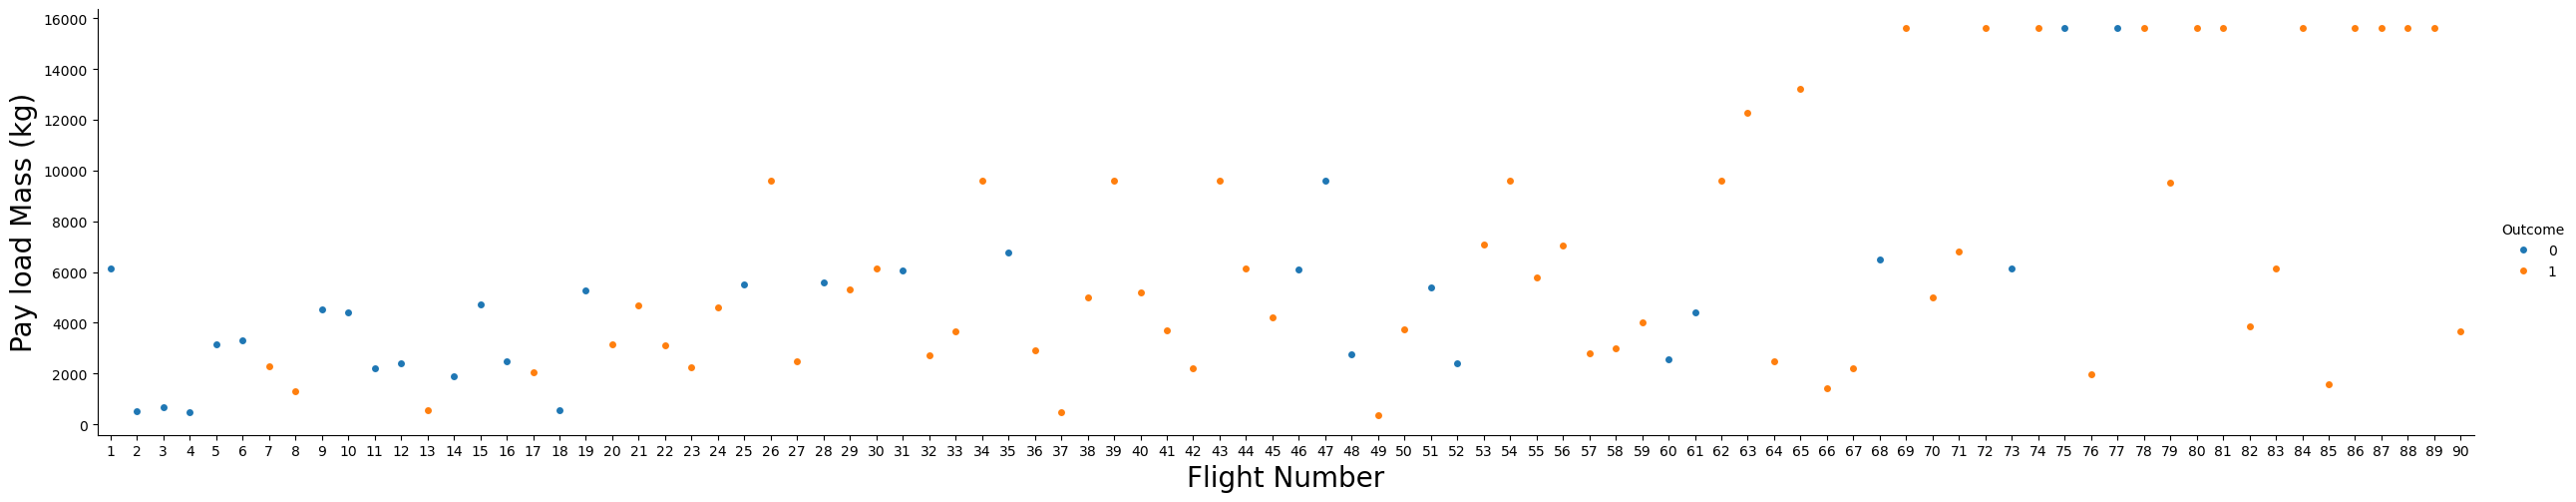

In [16]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Outcome", data=data_falcon9, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

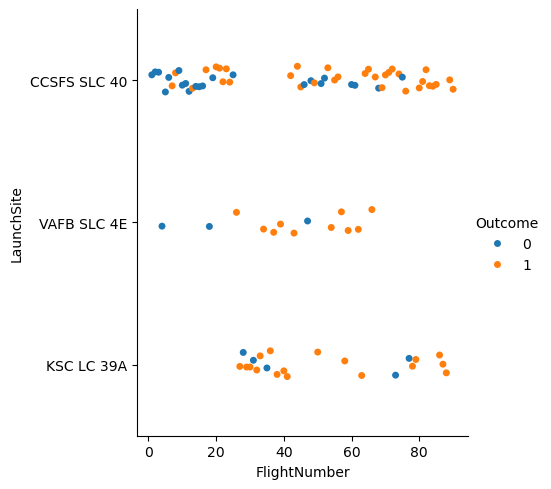

In [17]:
sns.catplot(x='FlightNumber', y='LaunchSite', hue='Outcome', data=data_falcon9)
plt.show()

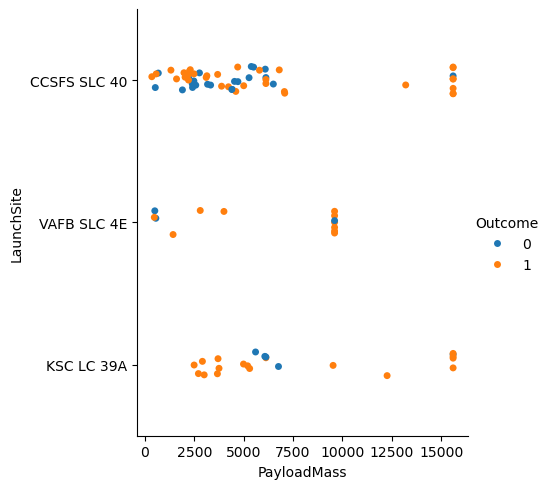

In [18]:
sns.catplot(x='PayloadMass', y='LaunchSite', data=data_falcon9, hue='Outcome')
plt.show()

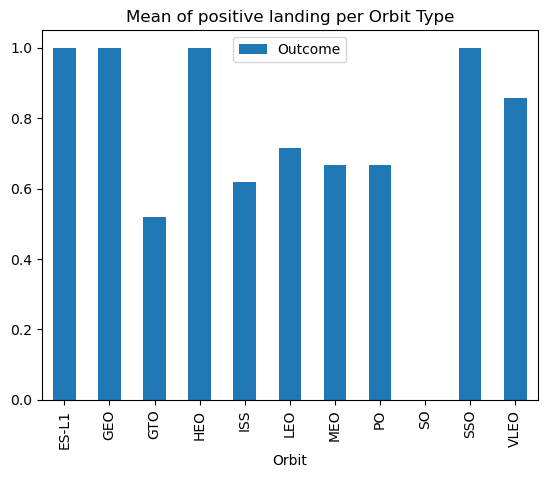

In [19]:
df_orbit = data_falcon9[['Orbit','Outcome']].groupby(['Orbit']).mean()
df_orbit.plot(kind='bar')
plt.title('Mean of positive landing per Orbit Type')
plt.show()

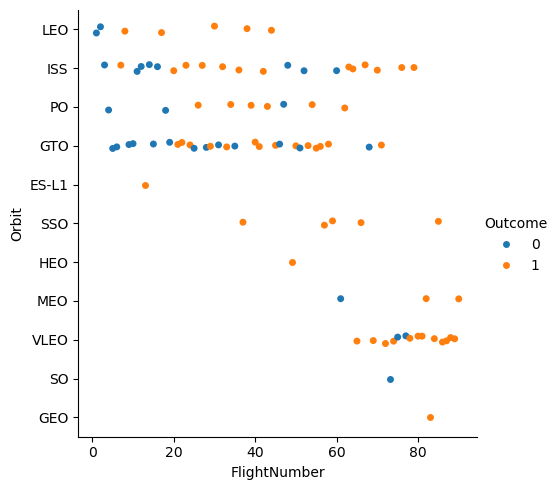

In [20]:
sns.catplot(x='FlightNumber', y='Orbit', data=data_falcon9, hue='Outcome')
plt.show()

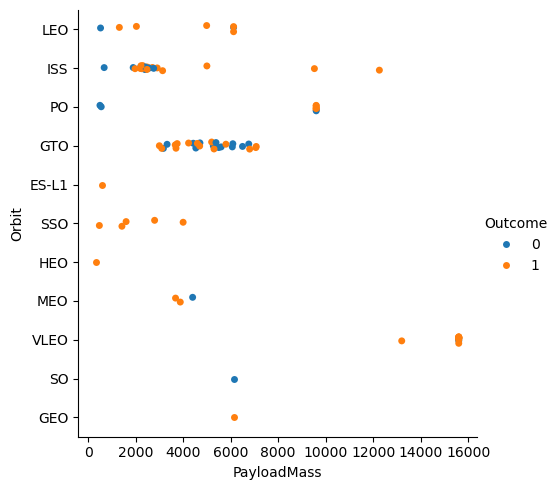

In [21]:
sns.catplot(x='PayloadMass', y='Orbit', data=data_falcon9, hue='Outcome')
plt.show()

In [22]:
year=[]
def Extract_year():
    for i in data_falcon9["Date"]:
        year.append(str(i).split("-")[0])
    return year
Extract_year()
data_falcon9['Date'] = year
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010,Falcon 9,6123.547647,LEO,CCSFS SLC 40,0,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012,Falcon 9,525.000000,LEO,CCSFS SLC 40,0,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013,Falcon 9,677.000000,ISS,CCSFS SLC 40,0,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013,Falcon 9,500.000000,PO,VAFB SLC 4E,0,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013,Falcon 9,3170.000000,GTO,CCSFS SLC 40,0,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


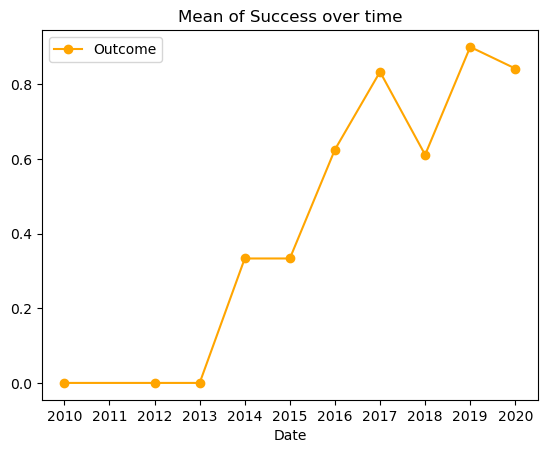

In [23]:
# Plot a line chart with x axis to be the extracted year and y axis to be the success rate
df_year = data_falcon9[['Date','Outcome']].groupby(['Date']).mean()
df_year.reset_index(inplace=True)
df_year = df_year.map(float)
df_year.plot(kind='line', x='Date', y='Outcome', marker='o', color='orange')
plt.title('Mean of Success over time')
plt.xticks(np.arange(np.min(df_year['Date']),np.max(df_year['Date'])+1,1))
plt.show()

In [24]:
features = data_falcon9[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
5,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
6,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
7,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
8,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004


In [25]:
features_one_hot = pd.get_dummies(features, columns=['Orbit', 'LaunchSite', 'LandingPad', 'Serial'], drop_first=False)
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,1,6123.547647,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
5,2,525.000000,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
6,3,677.000000,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
7,4,500.000000,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
8,5,3170.000000,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False


In [26]:
features_one_hot = features_one_hot.map(float)
features_one_hot.dtypes

FlightNumber    float64
PayloadMass     float64
Flights         float64
GridFins        float64
Reused          float64
                 ...   
Serial_B1056    float64
Serial_B1058    float64
Serial_B1059    float64
Serial_B1060    float64
Serial_B1062    float64
Length: 80, dtype: object

### SQL EDA

In [40]:
import sqlite3
%reload_ext sql
%sql sqlite:///my_data1.db

con = sqlite3.connect("my_data1.db")
cur = con.cursor()
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv")
df.to_sql("SPACEXTBL", con, if_exists='replace', index=False,method="multi")

101

In [44]:
%%sql 

DROP TABLE IF EXISTS SPACEXTABLE;

CREATE TABLE SPACEXTABLE as SELECT * from SPACEXTBL WHERE Date is not null

 * sqlite:///my_data1.db
Done.
Done.


[]

In [45]:
%%sql

SELECT * FROM SPACEXTABLE LIMIT 2

 * sqlite:///my_data1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)


In [46]:
%%sql

SELECT DISTINCT Launch_Site FROM SPACEXTABLE

 * sqlite:///my_data1.db
Done.


Launch_Site
CCAFS LC-40
VAFB SLC-4E
KSC LC-39A
CCAFS SLC-40


In [47]:
%%sql

SELECT * FROM SPACEXTABLE WHERE Launch_Site LIKE 'CCA%' LIMIT 5

 * sqlite:///my_data1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


In [48]:
%%sql

SELECT SUM(PAYLOAD_MASS__KG_) AS SUM_PAYLOAD FROM SPACEXTABLE
WHERE Customer LIKE '%NASA%'

 * sqlite:///my_data1.db
Done.


SUM_PAYLOAD
107010


In [49]:
%%sql

SELECT ROUND(AVG(PAYLOAD_MASS__KG_),2) AS AVG_PAYLOAD FROM SPACEXTABLE
WHERE Booster_Version LIKE '%F9 v1.1%'

 * sqlite:///my_data1.db
Done.


AVG_PAYLOAD
2534.67


In [51]:
%%sql

SELECT MIN(Date) AS Date FROM SPACEXTABLE
WHERE Mission_Outcome = 'Success'

 * sqlite:///my_data1.db
Done.


Date
2010-06-04


In [52]:
%%sql

SELECT Booster_Version FROM SPACEXTABLE
WHERE Mission_Outcome = 'Success' AND Landing_Outcome LIKE '%drone ship%' AND PAYLOAD_MASS__KG_ BETWEEN 4000 AND 6000

 * sqlite:///my_data1.db
Done.


Booster_Version
F9 FT B1020
F9 FT B1022
F9 FT B1026
F9 FT B1021.2
F9 FT B1031.2


In [53]:
%%sql

SELECT Mission_Outcome, COUNT(*) FROM SPACEXTABLE
GROUP BY Mission_Outcome

 * sqlite:///my_data1.db
Done.


Mission_Outcome,COUNT(*)
Failure (in flight),1
Success,98
Success,1
Success (payload status unclear),1


In [54]:
%%sql

SELECT Booster_Version FROM SPACEXTABLE
WHERE PAYLOAD_MASS__KG_ = (SELECT MAX(PAYLOAD_MASS__KG_) FROM SPACEXTABLE)

 * sqlite:///my_data1.db
Done.


Booster_Version
F9 B5 B1048.4
F9 B5 B1049.4
F9 B5 B1051.3
F9 B5 B1056.4
F9 B5 B1048.5
F9 B5 B1051.4
F9 B5 B1049.5
F9 B5 B1060.2
F9 B5 B1058.3
F9 B5 B1051.6


In [55]:
%%sql

SELECT 
    CASE substr(Date, 6, 2)
        WHEN '01' THEN 'January'
        WHEN '02' THEN 'February'
        WHEN '03' THEN 'March'
        WHEN '04' THEN 'April'
        WHEN '05' THEN 'May'
        WHEN '06' THEN 'June'
        WHEN '07' THEN 'July'
        WHEN '08' THEN 'August'
        WHEN '09' THEN 'September'
        WHEN '10' THEN 'October'
        WHEN '11' THEN 'November'
        WHEN '12' THEN 'December'
    END AS month_name,
    Landing_Outcome,
    Booster_Version,
    Launch_Site
FROM SPACEXTABLE
WHERE substr(Date, 0, 5) = '2015'
AND landing_outcome LIKE '%Failure%'

 * sqlite:///my_data1.db
Done.


month_name,Landing_Outcome,Booster_Version,Launch_Site
January,Failure (drone ship),F9 v1.1 B1012,CCAFS LC-40
April,Failure (drone ship),F9 v1.1 B1015,CCAFS LC-40


In [56]:
%%sql

SELECT Landing_Outcome, COUNT(Landing_Outcome) AS Count_Outcomes FROM SPACEXTABLE
WHERE Date BETWEEN '2010-06-04' AND '2017-03-20'
GROUP BY Landing_Outcome
ORDER BY Count_Outcomes DESC

 * sqlite:///my_data1.db
Done.


Landing_Outcome,Count_Outcomes
No attempt,10
Success (drone ship),5
Failure (drone ship),5
Success (ground pad),3
Controlled (ocean),3
Uncontrolled (ocean),2
Failure (parachute),2
Precluded (drone ship),1


### Folium

In [65]:
mymap = folium.Map(location=[40.112820, -96.936212], zoom_start=4, tiles='CartoDB Positron')

# Adicionar MousePosition para mostrar coordenadas ao passar o mouse
mouse_position = MousePosition(position='topright', separator=' | ', prefix="Coordinates:")
mouse_position.add_to(mymap)

# Criar um MarkerCluster para agrupar os marcadores
marker_cluster = MarkerCluster().add_to(mymap)

# Iterar sobre as posições no DataFrame e adicionar os marcadores ao cluster
for index, row in data_falcon9.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        icon=folium.DivIcon(html=f"""<div style="font-size: 8pt; color: white;">Lançamento {index+1}</div>""")
    ).add_to(marker_cluster)

# Mostrar o mapa
mymap.save("falcon9_map.html")
mymap

### Classifier

In [28]:
X = features_one_hot
Y = data_falcon9['Outcome'].to_numpy()
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=2)
print(f"""
Tamanhos:
      X_train: {X_train.shape}, Y_train: {Y_train.shape}
      X_test: {X_test.shape}, Y_test: {Y_test.shape}
""")


Tamanhos:
      X_train: (72, 80), Y_train: (72,)
      X_test: (18, 80), Y_test: (18,)



#### Logistic Regression

tuned hpyerparameters(best parameters):  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy :0.82222
Acurácia nos dados de teste:0.94444


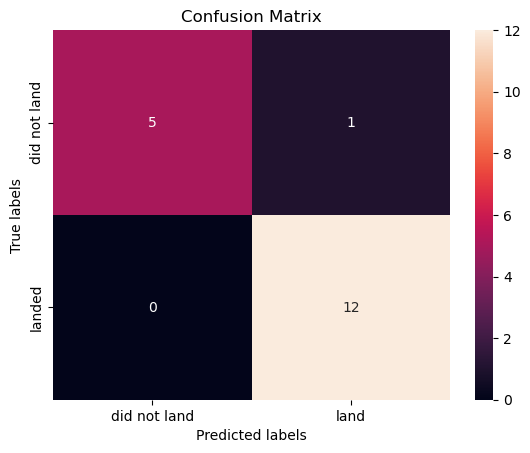

In [29]:
parameters ={'C':[0.001,0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs','liblinear']}
lr=LogisticRegression()
logreg_cv = GridSearchCV(estimator = lr, param_grid = parameters, cv = 10)
logreg_cv.fit(X, Y)
print("tuned hpyerparameters(best parameters): ",logreg_cv.best_params_)
print(f"accuracy :{logreg_cv.best_score_:.5f}")
accuracy_lr = logreg_cv.score(X_test, Y_test)
print(f"Acurácia nos dados de teste:{accuracy_lr:.5f}")
yhat = logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

#### Support Vector Machine

Melhores Parâmetros: {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
Acurácia no dados de treino: 0.84821
Acurácia nos dados de teste: 0.83333


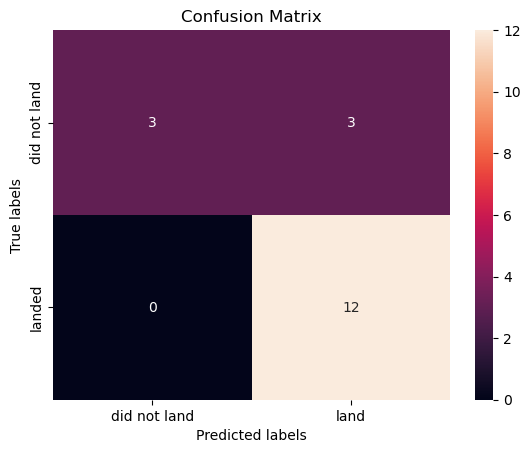

In [30]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
svm_cv = GridSearchCV(param_grid=parameters, estimator=svm, cv=10)
svm_cv.fit(X_train, Y_train)
print(f"Melhores Parâmetros: {svm_cv.best_params_}")
print(f"Acurácia no dados de treino: {svm_cv.best_score_:.5f}")
accuracy_svm = svm_cv.score(X_test, Y_test)
print(f"Acurácia nos dados de teste: {accuracy_svm:.5f}")
yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

#### Decision Tree

Melhores parâmetros: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}
Acurácio nos dados de treino: 0.87679
Acurácia nos dados de teste: 0.88889


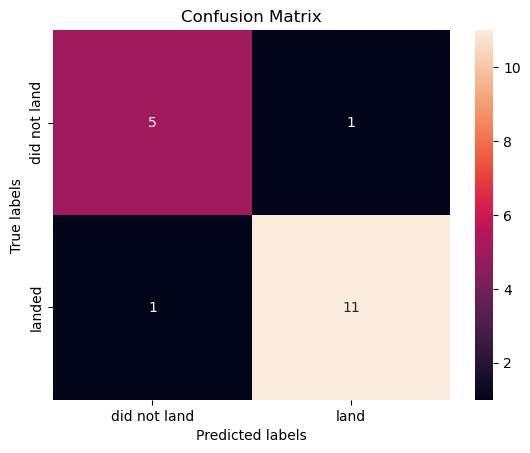

In [31]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['log2', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}
tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(estimator=tree, param_grid=parameters, cv=10)
tree_cv.fit(X_train, Y_train)
print(f"Melhores parâmetros: {tree_cv.best_params_}")
print(f"Acurácio nos dados de treino: {tree_cv.best_score_:.5f}")
accuracy_tree = tree_cv.score(X_test, Y_test)
print(f"Acurácia nos dados de teste: {accuracy_tree:.5f}")
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

#### K Neighbors

Melhores parâmetros: {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
Acurácio nos dados de treino: 0.83393
Acurácia nos dados de teste: 0.77778


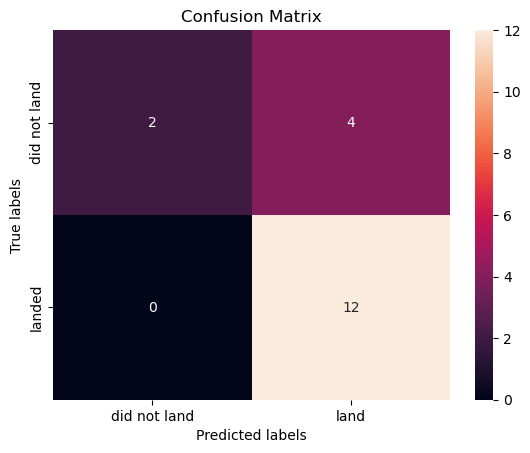

In [32]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}
KNN = KNeighborsClassifier()
knn_cv = GridSearchCV(estimator=KNN, param_grid=parameters, cv=10)
knn_cv.fit(X_train, Y_train)
print(f"Melhores parâmetros: {knn_cv.best_params_}")
print(f"Acurácio nos dados de treino: {knn_cv.best_score_:.5f}")
accuracy_knn = knn_cv.score(X_test, Y_test)
print(f"Acurácia nos dados de teste: {accuracy_knn:.5f}")
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

#### Comparação

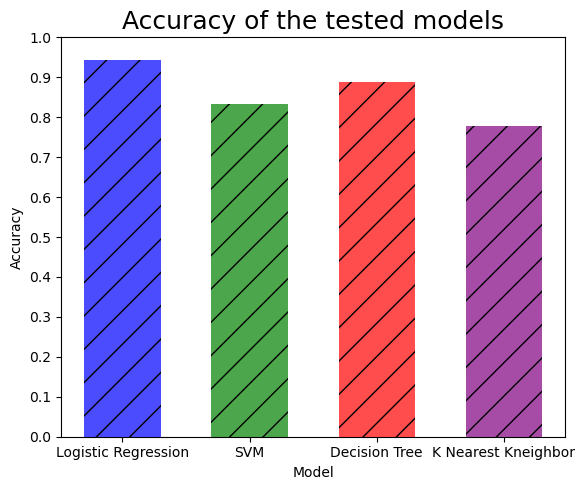

In [33]:
accuracy_df = pd.DataFrame({"Accuracy": [accuracy_lr, accuracy_svm, accuracy_tree, accuracy_knn]}, 
                           index=['Logistic Regression', 'SVM', 'Decision Tree', 'K Nearest Kneighbor'])

fig, ax = plt.subplots(figsize=(6,5))
ax.bar(height=accuracy_df['Accuracy'], 
       x=accuracy_df.index,
       width=0.6,
       color=['blue', 'green', 'red', 'purple'],
       alpha=0.7,
       label='Model Accuracy',
       hatch='/',
       zorder=3)
ax.set_title("Accuracy of the tested models", fontsize=18)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Model")
ax.set_yticks(np.arange(0,1.1,0.1))

plt.tight_layout()
plt.show()